<p style="font-size:36px"> Personalized cancer diagnosis </p>

# 1. Business Problem

## 1.1 Description

* Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/
* Data: Memorial Sloan Kettering Cancer Center (MSKCC)
* Download training_variants.zip and training_text.zip from Kaggle

#### Context
Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462

#### Problem Statement
Classify the given genetic variations/mutations based on evidence from text-based clinical literature

## 1.2. Source/Useful Links (Optional Reading material)

Some articles and reference blogs about the problem statement (this might give you somewhat better understanding about the domain)

1. https://www.forbes.com/sites/matthewherper/2017/06/03/a-new-cancer-drug-helped-almost-everyone-who-took-it-almost-heres-what-it-teaches-us/#2a44ee2f6b25
2. https://www.youtube.com/watch?v=qxXRKVompI8

## 1.3. Real-world/Business objectives and constraints.
* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

# 2. Machine Learning Problem Formulation

## 2.1. Data

### 2.1.1. Data Overview

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

### 2.1.2. Example Data Point

<h6>training_variants</h6>
<hr>
ID,Gene,Variation,Class<br>
0,FAM58A,Truncating Mutations,1 <br>
1,CBL,W802*,2 <br>
2,CBL,Q249E,2 <br>
...

<h6> training_text</h6>
<hr>
ID,Text <br>
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK10 silencing in increasing c-Raf and in conferring tamoxifen resistance to breast cancer cells. CDK10/cyclin M phosphorylates ETS2 in vitro, and in cells it positively controls ETS2 degradation by the proteasome. ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels. Altogether, our results reveal an additional regulatory mechanism for ETS2, which plays key roles in cancer and development. They also shed light on the molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1). The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2). Although discovered almost 20 y ago (3, 4), CDK10 remains one of the two CDKs without an identified cyclin partner. This knowledge gap has largely impeded the exploration of its biological functions. CDK10 can act as a positive cell cycle regulator in some cells (5, 6) or as a tumor suppressor in others (7, 8). CDK10 interacts with the ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2) transcription factor and inhibits its transcriptional activity through an unknown mechanism (9). CDK10 knockdown derepresses ETS2, which increases the expression of the c-Raf protein kinase, activates the MAPK pathway, and induces resistance of MCF7 cells to tamoxifen (6). ...

## 2.2. Mapping the real-world problem to an ML problem

### 2.2.1. Type of Machine Learning Problem¶
There are nine different classes a genetic mutation can be classified into => Multi class classification problem

### 2.2.2. Performance Metric
Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation

Metric(s): 
* Multi class log-loss 
* Confusion matrix 

### 2.2.3. Machine Learing Objectives and Constraints

Objective: Predict the probability of each data-point belonging to each of the nine classes.

Constraints:
* Interpretability
* Class probabilities are needed.
* Penalize the errors in class probabilites => Metric is Log-loss.
* No Latency constraints.

## 2.3. Train, CV and Test Datasets
Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

# 3. Exploratory Data Analysis

In [284]:
## import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Miscellaneous
import re
import time
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from scipy.sparse import hstack
from nltk.corpus import stopwords

# Sklearn
from sklearn.preprocessing import normalize ## Scale input vectors to unit norm (vector length)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier  ## Need to install mlxtend
from sklearn.ensemble import VotingClassifier

from sklearn.calibration import CalibratedClassifierCV  ## Probability Caliberation

# Evaluation Metrics
from sklearn.metrics.classification import accuracy_score, confusion_matrix, log_loss

## 3.1. Reading Data

### 3.1.1. Reading Gene and Variation Data

In [2]:
data = pd.read_csv('training/training_variants')

In [3]:
data.shape

(3321, 4)

In [5]:
data.columns.values

array(['ID', 'Gene', 'Variation', 'Class'], dtype=object)

In [7]:
data.head(10)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


### 3.1.2. Reading Text Data

In [8]:
# note the seprator in this file
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [9]:
data_text.shape

(3321, 2)

In [10]:
data_text.columns.values

array(['ID', 'TEXT'], dtype=object)

In [12]:
data_text.head(10)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
5,5,Oncogenic mutations in the monomeric Casitas B...
6,6,Oncogenic mutations in the monomeric Casitas B...
7,7,CBL is a negative regulator of activated recep...
8,8,Abstract Juvenile myelomonocytic leukemia (JM...
9,9,Abstract Juvenile myelomonocytic leukemia (JM...


### 3.1.3. Preprocessing of text
* Remove stopwords
* Replace all special characters by space
* Remove multiple spaces
* Lower casing

In [25]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [10]:
# text processing stage.
start_time = time.clock()

for index, row in data_text[:10].iterrows():
    nlp_preprocessing(row['TEXT'], index, 'TEXT')

print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

Time took for preprocessing the text : 557.3119577188 seconds


In [29]:
# Just make a visual confirmation of pre-processing
data_text.head(10)

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...
5,5,oncogenic mutations monomeric casitas b lineag...
6,6,oncogenic mutations monomeric casitas b lineag...
7,7,cbl negative regulator activated receptor tyro...
8,8,abstract juvenile myelomonocytic leukemia jmml...
9,9,abstract juvenile myelomonocytic leukemia jmml...


#### Merging both gene_variations and text data based on ID

In [11]:
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


#### Save the dataframe so as not to preprocess everytime

In [12]:
result.to_pickle("result_after_preprocessing")

#### Read the saved preprocessed dataframe

In [30]:
result = pd.read_pickle("result_after_preprocessing")

## 3.1.4. Test, Train and Cross Validation Split

#### 3.1.4.1. Splitting data into train, test and cross validation (64:20:16)

In [31]:
y_true = result['Class'].values

## Below we replace the spaces into uncerscore in the gene and variation features
## So that we have only one value for them
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


What is straify in train_test_split method?

Stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset. i.e. We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set

In [32]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

Check the number of data points in train, cv and test sets

In [33]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


#### 3.1.4.2. Distribution of y_i's in Train, Test and Cross Validation datasets

In [49]:
# pd.sort_index() will sort the output of "value_counts" based on index.
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

Distribution in train set

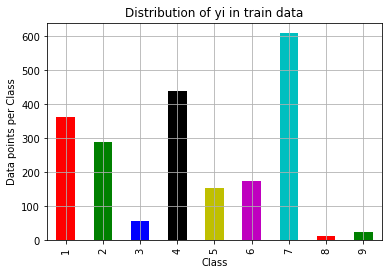

Number of data points in class 7 : 609 i.e. 28.672 %
Number of data points in class 4 : 439 i.e. 20.669 %
Number of data points in class 1 : 363 i.e. 17.09 %
Number of data points in class 2 : 289 i.e. 13.606 %
Number of data points in class 6 : 176 i.e. 8.286 %
Number of data points in class 5 : 155 i.e. 7.298 %
Number of data points in class 3 : 57 i.e. 2.684 %
Number of data points in class 9 : 24 i.e. 1.13 %
Number of data points in class 8 : 12 i.e. 0.565 %


In [51]:
train_class_distribution.plot(kind='bar', color = 'rgbkymc')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

## Print the distributions in the decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], 
          'i.e.', 
          np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), 
          '%')

Distribution in test set

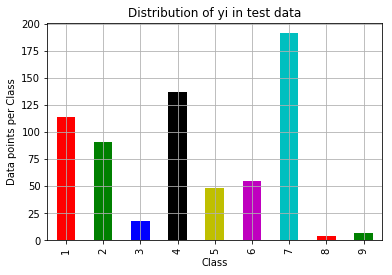

Number of data points in class 7 : 191 i.e. 28.722 %
Number of data points in class 4 : 137 i.e. 20.602 %
Number of data points in class 1 : 114 i.e. 17.143 %
Number of data points in class 2 : 91 i.e. 13.684 %
Number of data points in class 6 : 55 i.e. 8.271 %
Number of data points in class 5 : 48 i.e. 7.218 %
Number of data points in class 3 : 18 i.e. 2.707 %
Number of data points in class 9 : 7 i.e. 1.053 %
Number of data points in class 8 : 4 i.e. 0.602 %


In [52]:
test_class_distribution.plot(kind='bar', color = 'rgbkymc')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

## Print the distributions in the decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], 
          'i.e.', 
          np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3),
          '%')

Distribution in cv set

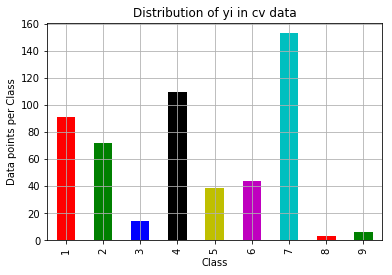

Number of data points in class 7 : 153 i.e. 28.759 %
Number of data points in class 4 : 110 i.e. 20.677 %
Number of data points in class 1 : 91 i.e. 17.105 %
Number of data points in class 2 : 72 i.e. 13.534 %
Number of data points in class 6 : 44 i.e. 8.271 %
Number of data points in class 5 : 39 i.e. 7.331 %
Number of data points in class 3 : 14 i.e. 2.632 %
Number of data points in class 9 : 6 i.e. 1.128 %
Number of data points in class 8 : 3 i.e. 0.564 %


In [53]:
cv_class_distribution.plot(kind='bar', color = 'rgbkymc')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cv data')
plt.grid()
plt.show()

## Print the distributions in the decreasing order
sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], 
          'i.e.', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), 
          '%')

#### Note: Due to stratification, the distributions of all classes are almost similar in all the 3 sets

## 3.2 Prediction using a 'Random' Model
In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1.

#### Below function is a utility function to print confusion, precision and recall matrices using heatmaps

In [175]:
def plot_confusion_matrix(test_y, predict_y):
    '''
    Inputs:
        1. test_y => Array of actual class of the train/cv/test points
        2. predict_y => Array of predicted class of the train/cv/test points
        
    Output:
        Function prints the confusion matrix, precision matrix and recall matrix using heatmaps
        Reference "https://seaborn.pydata.org/generated/seaborn.heatmap.html"
    '''
    labels = [1,2,3,4,5,6,7,8,9]
    
    ## Calculate the Confusion Matrix
    C = confusion_matrix(test_y, predict_y)
    
    ## Print Confusion Matrix using heatmap
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    ## Calculate the Precision Matrix
    ## Divide each element of the confusion matrix with the sum of elements in that column
    A = C/C.sum(axis=0)
    
    ## Print Precision matrix using heatmap
    print("-"*20, "Precision matrix (Column Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    ## Calculate the Recall Matrix
    ## Divide each element of the confusion matrix with the sum of elements in that row
    B = ((C.T)/(C.sum(axis=1))).T
    
    ## Print Recall matrix using heatmap
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

#### Building a Random Model - For Hypothesis Testing
* We need to generate 9 numbers such that they sum to 1.
* One solution is to genarate 9 numbers and divide each of the numbers by their sum.

Log loss on Test Data using Random Model 2.47850731161
-------------------- Confusion matrix --------------------


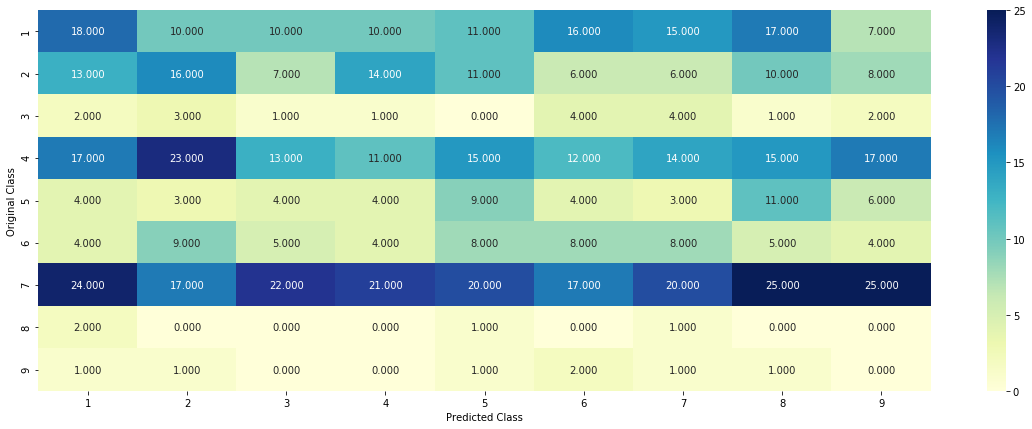

-------------------- Precision matrix (Column Sum=1) --------------------


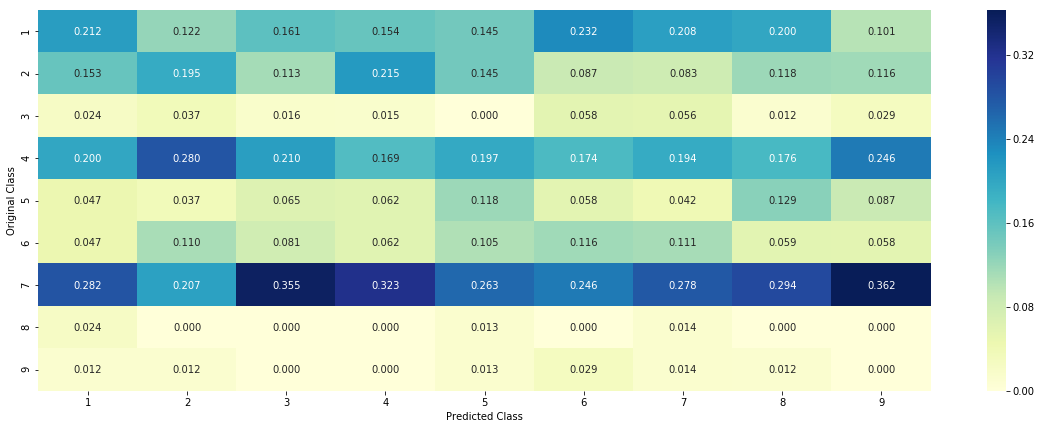

-------------------- Recall matrix (Row sum=1) --------------------


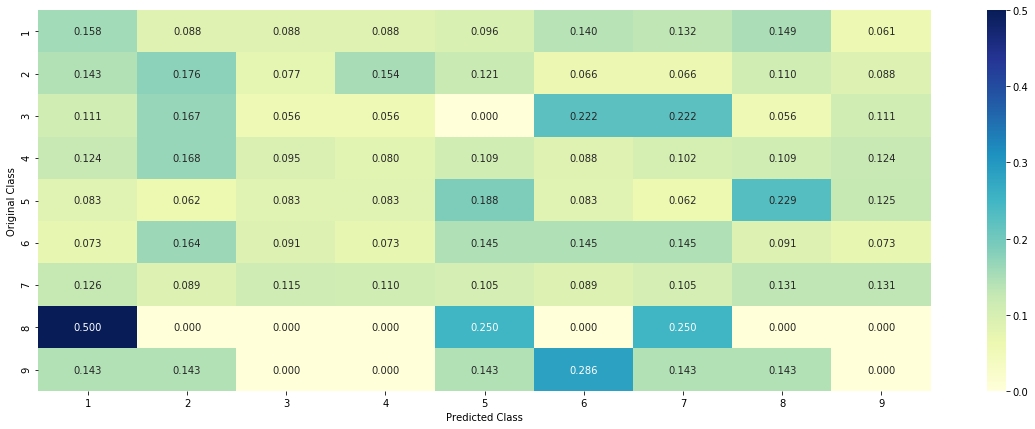

In [176]:
test_data_len = test_df.shape[0]

## Test-Set error.
## Create a output array that has exactly same as the test data
## For each point, generate a vector of size 9
test_predicted_y = np.zeros((test_data_len,9))

for i in range(test_data_len):
    rand_probs = np.random.rand(9)  # Generate 9 values between 0 and 1
    test_predicted_y[i] = rand_probs/sum(rand_probs)  # Divide each value by the sum
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y))


predicted_y = np.argmax(test_predicted_y, axis=1) # Predicted class is the one with highest probability
plot_confusion_matrix(y_test, predicted_y+1)  # +1 because index starts from 0 but classes are 1 to 9

## 3.3 Univariate Analysis

### 3.2.1 Univariate Analysis on Gene Feature

Q1. Gene, What type of feature it is ?

Ans. Gene is a categorical variable

Q2. How many categories are there and How they are distributed?

##### Note: Only looking at the training data

In [287]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 235
BRCA1     165
TP53      102
EGFR       90
BRCA2      83
PTEN       83
BRAF       64
KIT        62
ERBB2      45
PDGFRA     42
ALK        40
Name: Gene, dtype: int64


In [288]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 235 different categories of genes in the train data, and they are distibuted as follows


##### Plotting the histogram for the distribution of genes

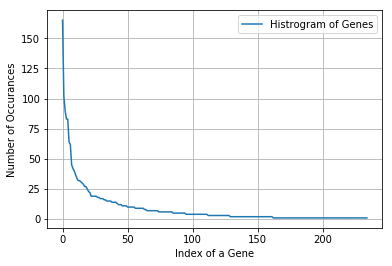

In [65]:
s = unique_genes.values
plt.plot(s, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()

**Observation:** It is a skewed distribution

##### Plotting the CDF below

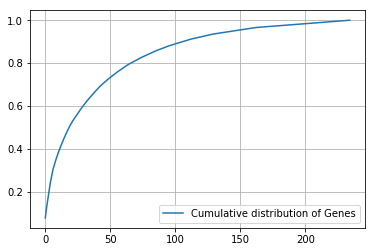

In [71]:
c = np.cumsum(s/sum(s))
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()

**Observation:** Top 50 genes contribute to almost 75% of the data.

Q3. How to featurize this Gene feature ?

There are various techniques that can be used to featurize the categorical varaibles but in this case study we will create **One hot Encoding** featurization

##### One-hot encoding of Gene feature (using CountVectorizer)

In [72]:
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [73]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 234)


Q4. How good is this gene feature in predicting y_i?

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

##### Building a logistic regression model with only "gene"(with one-hot encoding) as the feature

In [76]:
alpha = [10 ** x for x in range(-5, 1)] ## hyperparameter for SGD classifier

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log')
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The cv log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))

For values of alpha =  1e-05 The cv log loss is: 1.39895935714
For values of alpha =  0.0001 The cv log loss is: 1.21498623916
For values of alpha =  0.001 The cv log loss is: 1.23902719075
For values of alpha =  0.01 The cv log loss is: 1.35090391528
For values of alpha =  0.1 The cv log loss is: 1.45944097794
For values of alpha =  1 The cv log loss is: 1.50081506061


Using annotation below, otherwise the reading is very difficult.

Later we will use the log-scale which will make it even more readable

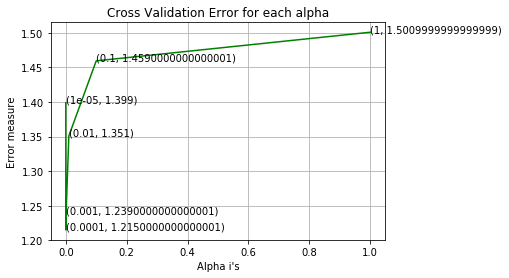

In [77]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")

Building the model with the optimal hyperparameter and calculating: train, cv and test log loss

In [75]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 1.03264482079
For values of best alpha =  0.0001 The cross validation log loss is: 1.22269848631
For values of best alpha =  0.0001 The test log loss is: 1.212631386


Q5. Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?

Ans. Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error.

##### Testing the stability

In [82]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  235  genes in train dataset?
Ans
1. In test data 641 out of 665 : 96.39097744360903
2. In cross validation data 516 out of  532 : 96.99248120300751


### 3.2.2 Univariate Analysis on Variation Feature

Q7. Variation, What type of feature is it ?

Ans. Variation is a categorical variable

Q8. How many categories are there?

In [83]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1930
Truncating_Mutations    60
Deletion                55
Amplification           38
Fusions                 19
G12V                     3
Overexpression           3
Q61R                     3
C618R                    2
P130S                    2
Q209L                    2
Name: Variation, dtype: int64


In [84]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1930 different categories of variations in the train data, and they are distibuted as follows


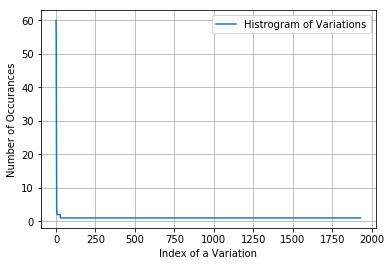

In [87]:
s = unique_variations.values
plt.plot(s, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()

**Observation:** Most of the data points have the variation value which is unique

[ 0.02824859  0.05414313  0.0720339  ...,  0.99905838  0.99952919  1.        ]


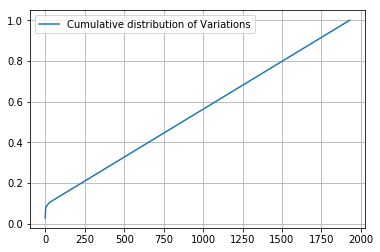

In [88]:
c = np.cumsum(s/sum(s))
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

Q9. How to featurize this Variation feature ?

* One hot Encoding

##### One-hot encoding of Variation feature (using CountVectorizer)

In [89]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [90]:
print("train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature: (2124, 1954)


Q10. How good is this Variation feature in predicting y_i?

Let's build a model just like the earlier!

In [91]:
alpha = [10 ** x for x in range(-5, 1)]  ## Hyperparameter tuning

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log')
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))

For values of alpha =  1e-05 The log loss is: 1.71925852897
For values of alpha =  0.0001 The log loss is: 1.70231078179
For values of alpha =  0.001 The log loss is: 1.7066823267
For values of alpha =  0.01 The log loss is: 1.71337571551
For values of alpha =  0.1 The log loss is: 1.72399572932
For values of alpha =  1 The log loss is: 1.72754499304


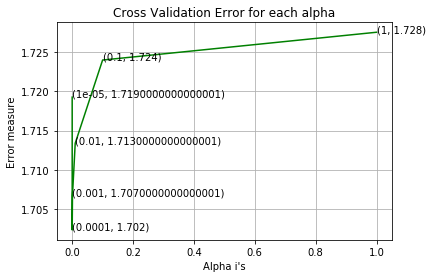

In [92]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")

Building the model with the optimal hyperparameter and calculating: train, cv and test log loss

In [93]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best alpha =  0.0001 The train log loss is: 0.789178650179
For values of best alpha =  0.0001 The cross validation log loss is: 1.70481565781
For values of best alpha =  0.0001 The test log loss is: 1.71484055246


Q11. Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?

Ans. Not sure! But lets be very sure using the below analysis.

In [94]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")

test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1930  genes in test and cross validation data sets?
Ans
1. In test data 66 out of 665 : 9.924812030075188
2. In cross validation data 62 out of  532 : 11.654135338345863


### 3.2.3 Univariate Analysis on Text Feature

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

##### One-hot encoding for TEXT feature

In [95]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
# train_text_fea_counts[i] basically contains the count of how many times feature 'i' occurs in train data
# A1 basially flattens a 2-D array into a 1-D array - https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.matrix.A1.html
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
# text_fea_dict is a dictionary with word as key and no of times it occurs in train data as value
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53204


##### Normalizing every feature
Refer: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html

This is the same normalization that we do for every column to bring each value in the scale of 0 to 1

In [97]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same "text_vectorizer" that was trained on train data
# be careful to use the method transform() and not fit_transform()
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same "text_vectorizer" that was trained on train data
# be careful to use the method transform() and not fit_transform()
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

##### Checking the distribution of words

In [124]:
## Reference => https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

**Note:**

**sorted_text_fea_dict** is similar to text_fea_dict, but is sorted on values.

** sorted_text_occur** is an array of the values of sorted_text_fea_dict

In [132]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5606, 4: 3502, 5: 2995, 6: 2713, 8: 2168, 7: 2068, 10: 1543, 9: 1542, 12: 1373, 11: 1092, 16: 869, 15: 864, 14: 812, 17: 807, 13: 798, 18: 727, 20: 573, 19: 552, 24: 552, 21: 471, 22: 446, 26: 377, 28: 372, 27: 368, 40: 351, 25: 349, 23: 348, 30: 348, 31: 318, 32: 308, 36: 292, 46: 279, 35: 267, 29: 265, 42: 255, 34: 253, 33: 240, 38: 212, 44: 192, 39: 187, 41: 184, 48: 183, 37: 179, 45: 178, 43: 173, 54: 170, 50: 164, 60: 163, 51: 156, 52: 149, 57: 146, 47: 144, 56: 139, 49: 133, 64: 130, 53: 125, 59: 124, 55: 119, 58: 119, 63: 115, 65: 113, 70: 111, 66: 109, 62: 102, 61: 101, 68: 101, 72: 101, 84: 101, 69: 90, 73: 89, 67: 88, 76: 84, 79: 79, 80: 78, 71: 77, 86: 77, 90: 77, 75: 76, 78: 76, 81: 72, 92: 72, 91: 71, 85: 69, 87: 69, 77: 68, 82: 68, 96: 68, 74: 66, 83: 65, 93: 65, 102: 65, 89: 61, 120: 59, 99: 58, 100: 58, 95: 56, 135: 56, 104: 54, 126: 54, 88: 52, 98: 52, 108: 52, 114: 52, 109: 51, 117: 51, 113: 50, 106: 49, 119: 49, 124: 49, 101: 47, 123: 47, 136: 44, 146: 44

**Explanation:** This means there are 5606 words which occur 3 times; 3502 words which occur 4 times and so on ...

##### Training a Logistic Regression with only TEXT (one-hot encoded) as the feature

In [133]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.35523227554
For values of alpha =  0.0001 The log loss is: 1.30226395852
For values of alpha =  0.001 The log loss is: 1.19120756149
For values of alpha =  0.01 The log loss is: 1.23351215742
For values of alpha =  0.1 The log loss is: 1.49091494439
For values of alpha =  1 The log loss is: 1.7078116806


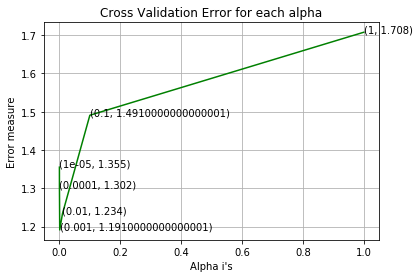

In [134]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")

In [135]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))


For values of best alpha =  0.001 The train log loss is: 0.776493894106
For values of best alpha =  0.001 The cross validation log loss is: 1.17937908819
For values of best alpha =  0.001 The test log loss is: 1.14193026329


Q. Is the Text feature stable across all the data sets (Test, Train, Cross validation)?

Ans. Yes, it seems like!

In [136]:
def get_intersec_text(df):
    '''
       Function takes dataframe "df" as input (either cv dataframe or test dataframe)
       It returns the number of words common in df and training dataset
       Note: "train_text_features" is already computed above
    '''
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names() ## Get feature names in df

    len1 = len(set(df_text_features))  ## No of unique words in df
    len2 = len(set(train_text_features) & set(df_text_features))  ## No of common words in df and training set
    return len1,len2

In [137]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.127 % of word of test data appeared in train data
96.833 % of word of Cross Validation appeared in train data


# 4. Machine Learning Models

#### Data preparation for ML Models - Misc. function for ML models

#### Below function is used to get model interpretability
For the given indices, we will print the name of the features and we will check whether the feature present in the test point text or not

In [141]:
## These variables are used in the below function

## Create three objects of CountVectorizer
gene_count_vec = CountVectorizer()
var_count_vec = CountVectorizer()
text_count_vec = CountVectorizer(min_df=3)

## Get one-hot encoding for "Gene" and "Variation"
gene_vec = gene_count_vec.fit(train_df['Gene'])
var_vec  = var_count_vec.fit(train_df['Variation'])

train_gene_features = gene_count_vec.get_feature_names()
train_var_features = var_count_vec.get_feature_names()
# For Text, we use "train_text_features" - which is already calculated above

## Calculate the length of one-hot encoded vectors for "Gene" and "Variation"
fea1_len = len(train_gene_features)
fea2_len = len(train_var_features)

In [153]:
def get_impfeature_names(indices, text, gene, var, no_features):
    '''
    Inputs:
        Let, no_features = k
        indices => Array of indices for the top "k" features corresponding to the predicted class
                   of the test point; sorted in the descending order (decreasing order of importance)
                   
            Note:
            Top K features are selected from different models using different as follows:
                i) From Naive Bayes, these are the features with highest likelihood probabilities
                ii) From LR or SVM, these are the coefficients with the highest wights
                iii) For Random Forest, these are features which help the most to reduce the overall entropy/gini impurity
                
        text => the "TEXT" value of the test point
        gene => the "Gene" value of the test point
        var => The "Variation" value of the test point
    
    Output:
        Of the top k features, print how many are actually present in the test point
        
    
    For a single data point we have the below structure:
    ______________________________________________________________________
    |_____________________|_______________________|_______________________|
    <----one hot gene-----><---one hot variation--><----one hot TEXT------>
    <------fea1_len-------><------fea2_len-------->
    
    i.e. We concatenate all the three one hot encoded vectors in the above sequence
    
    '''
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            ## This is a gene feature
            ## Get the name of the vth Gene feature
            word = train_gene_features[v]
            ## If the word matches with the "Gene" feature of the test point, print it
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point".format(word))
        elif (v < fea1_len+fea2_len):
            ## This is a variation feature
            ## Get the name of the vth Varation feature
            ## If the word matches with the "Variation" feature of the test point, print it
            word = train_var_features[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point".format(word))
        else:
            ## This is a TEXT feature
            ## Get the name of the vth TEXT feature
            word = train_text_features[v-(fea1_len+fea2_len)]
            ## If the word present in the "TEXT" feature of the test point, print it
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point".format(word))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

#### Concatenating the three types of features

In [144]:
# merging gene, variance and text features

## One-Hot encoded Vectors:

## For train dataset
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()

## For test dataset
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()

## For CV dataset
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))
cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()


##### Checking the dimensionality for one-hot encoded vectors

In [145]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55392)
(number of data points * number of features) in test data =  (665, 55392)
(number of data points * number of features) in cross validation data = (532, 55392)


##### For one hot encoding the dimensionality of the data is 55392

## 4.1. Base Line Model

### 4.1.1. Naive Bayes with one-hot encoded features

#### 4.1.1.1. Hyper parameter tuning

In [178]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs))

for alpha = 1e-05
Log Loss : 1.28689388862
for alpha = 0.0001
Log Loss : 1.28657385069
for alpha = 0.001
Log Loss : 1.28351257857
for alpha = 0.1
Log Loss : 1.2623763997
for alpha = 1
Log Loss : 1.2906066716
for alpha = 10
Log Loss : 1.36730718759
for alpha = 100
Log Loss : 1.35084070348
for alpha = 1000
Log Loss : 1.28265583786


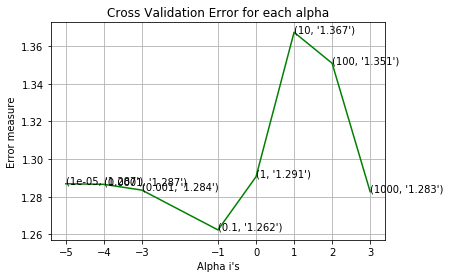

In [179]:
fig, ax = plt.subplots()
## Plotting the log of alpha makes the points much more visible
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")

In [180]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best alpha =  0.1 The train log loss is: 0.885106831134
For values of best alpha =  0.1 The cross validation log loss is: 1.2623763997
For values of best alpha =  0.1 The test log loss is: 1.25230911979


#### 4.1.1.2. Testing the model with best hyper paramters

Number of mis-classified points : 0.38646616541353385
-------------------- Confusion matrix --------------------


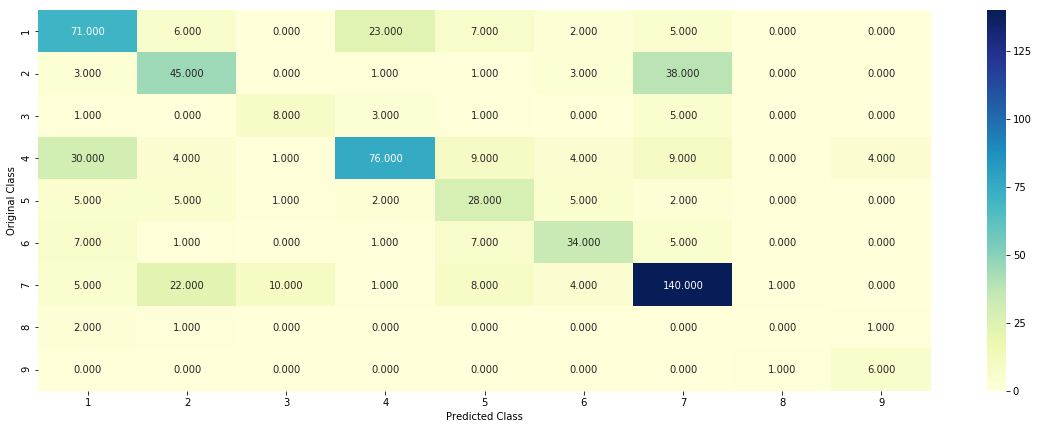

-------------------- Precision matrix (Column Sum=1) --------------------


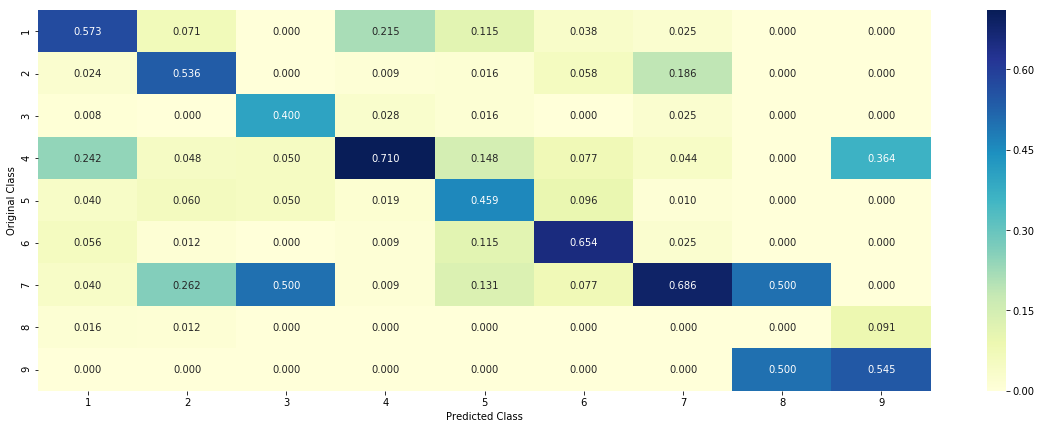

-------------------- Recall matrix (Row sum=1) --------------------


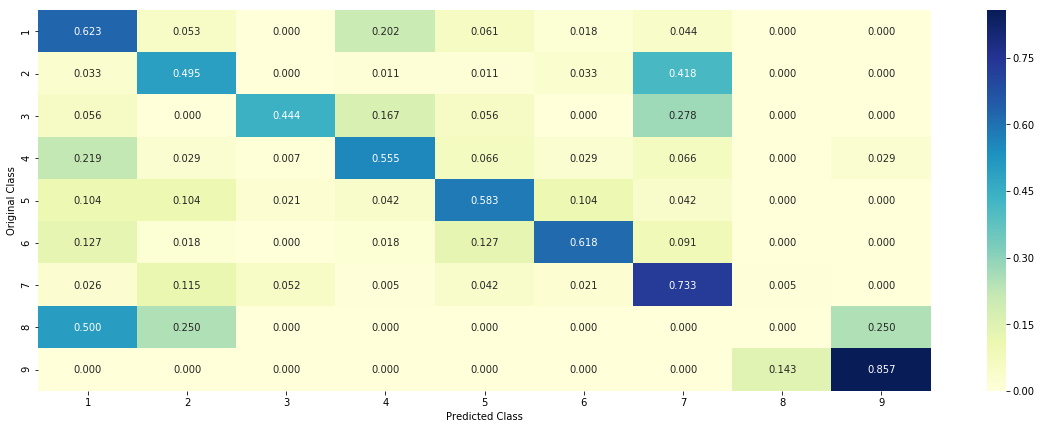

In [257]:
pred_y = sig_clf.predict(test_x_onehotCoding)
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((pred_y - y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,pred_y)

#### 4.1.1.3. Feature Importance (Correctly classified point as an example)

In [220]:
test_point_index = 3  ## Change the index to view for different test points
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[ 0.0788  0.0731  0.0129  0.097   0.0379  0.0348  0.6594  0.0033  0.0027]]
Actual Class : 7
--------------------------------------------------
17 Text feature [kinase] present in test data point
18 Text feature [presence] present in test data point
19 Text feature [activating] present in test data point
20 Text feature [well] present in test data point
21 Text feature [downstream] present in test data point
22 Text feature [recently] present in test data point
23 Text feature [activation] present in test data point
24 Text feature [contrast] present in test data point
25 Text feature [independent] present in test data point
26 Text feature [potential] present in test data point
27 Text feature [expressing] present in test data point
28 Text feature [shown] present in test data point
30 Text feature [however] present in test data point
31 Text feature [inhibitor] present in test data point
32 Text feature [also] present in test data po

#### 4.1.1.3. Feature Importance (Incorrectly classified point as an example)

In [221]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[ 0.2451  0.386   0.0157  0.1175  0.0458  0.0423  0.1403  0.004   0.0032]]
Actual Class : 1
--------------------------------------------------
16 Text feature [identified] present in test data point
17 Text feature [sequencing] present in test data point
22 Text feature [molecular] present in test data point
23 Text feature [clinical] present in test data point
24 Text feature [including] present in test data point
25 Text feature [novel] present in test data point
26 Text feature [patient] present in test data point
29 Text feature [harbored] present in test data point
30 Text feature [found] present in test data point
31 Text feature [another] present in test data point
32 Text feature [revealed] present in test data point
33 Text feature [using] present in test data point
35 Text feature [may] present in test data point
36 Text feature [harbor] present in test data point
37 Text feature [kinase] present in test data point
39 Text f

## 4.3. Logistic Regression with one-hot encoded features

### 4.3.1. LR With Class balancing

#### 4.3.1.1. Hyper paramter tuning

In [222]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

for alpha = 1e-06
Log Loss : 1.36587466992
for alpha = 1e-05
Log Loss : 1.37498015841
for alpha = 0.0001
Log Loss : 1.31187372624
for alpha = 0.001
Log Loss : 1.12090945595
for alpha = 0.01
Log Loss : 1.1227408039
for alpha = 0.1
Log Loss : 1.46698716148
for alpha = 1
Log Loss : 1.71536625548
for alpha = 10
Log Loss : 1.74238732808
for alpha = 100
Log Loss : 1.74513554217


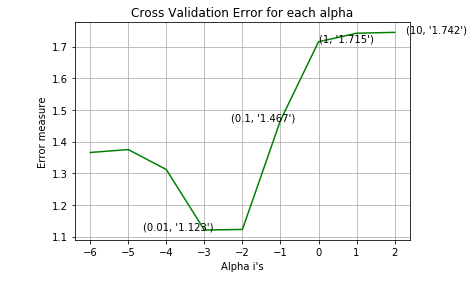

In [223]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")

In [224]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best alpha =  0.001 The train log loss is: 0.637669292782
For values of best alpha =  0.001 The cross validation log loss is: 1.10085701173
For values of best alpha =  0.001 The test log loss is: 1.0761284859


#### 4.3.1.2. Testing the model with best hyper paramters

Number of mis-classified points : 0.3744360902255639
-------------------- Confusion matrix --------------------


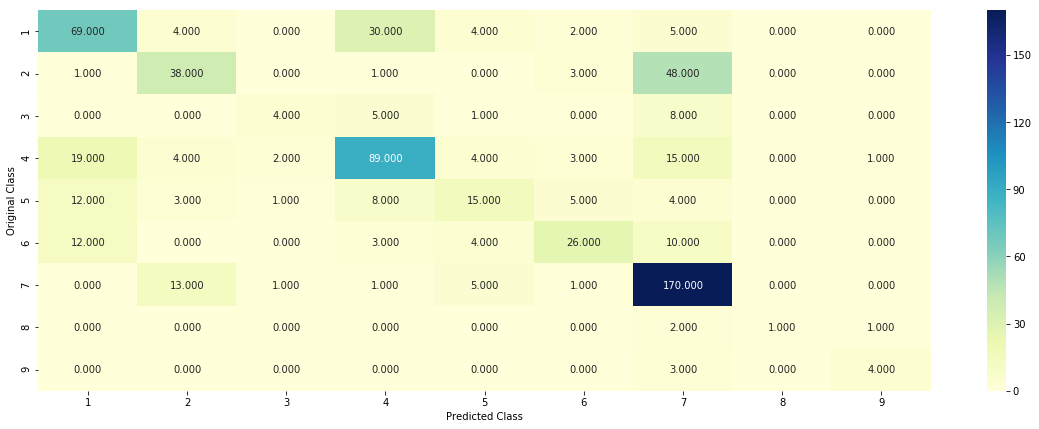

-------------------- Precision matrix (Column Sum=1) --------------------


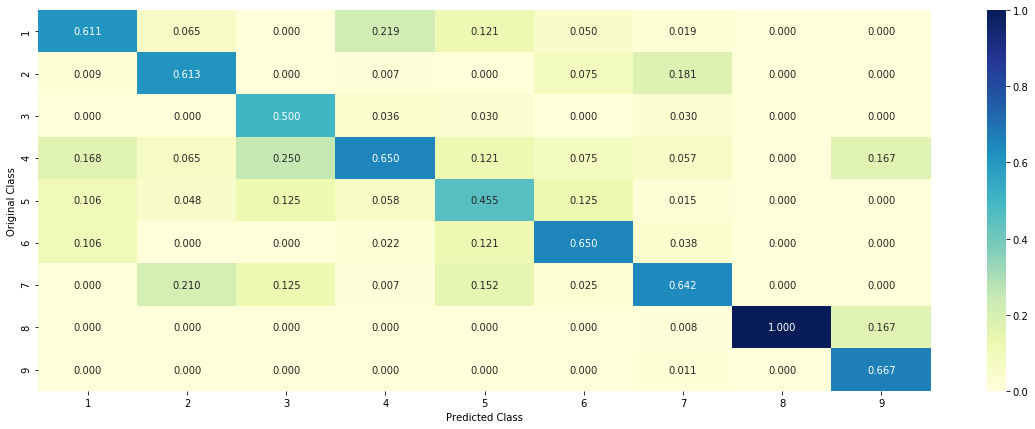

-------------------- Recall matrix (Row sum=1) --------------------


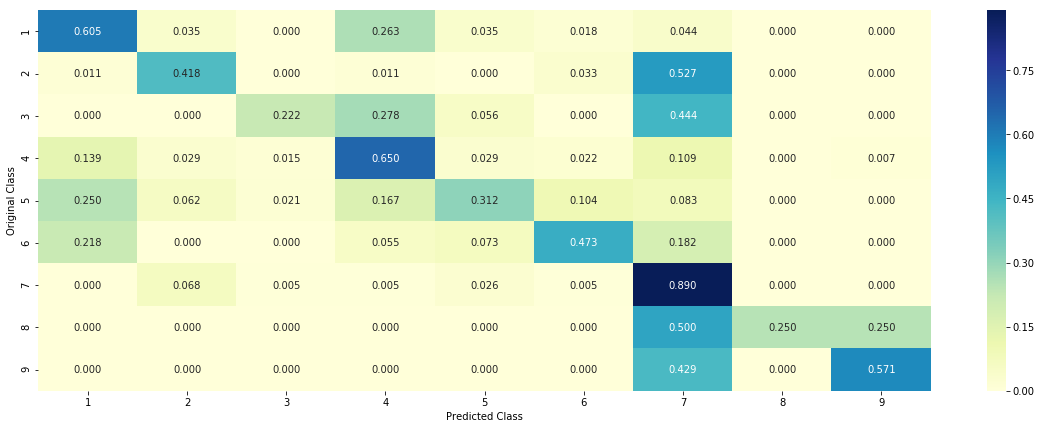

In [259]:
pred_y = sig_clf.predict(test_x_onehotCoding)
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((pred_y - y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,pred_y)

#### 4.3.1.3. Feature Importance

##### 4.3.1.3.1. Correctly Classified point

In [229]:
test_point_index = 3
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[ 0.0149  0.0325  0.0078  0.0124  0.0609  0.008   0.8552  0.0052  0.0031]]
Actual Class : 7
--------------------------------------------------
107 Text feature [constitutively] present in test data point
116 Text feature [balb] present in test data point
122 Text feature [loss] present in test data point
132 Text feature [missense] present in test data point
140 Text feature [transforming] present in test data point
158 Text feature [constitutive] present in test data point
221 Text feature [expressing] present in test data point
227 Text feature [nude] present in test data point
253 Text feature [oncogenes] present in test data point
260 Text feature [function] present in test data point
277 Text feature [activated] present in test data point
306 Text feature [transformed] present in test data point
367 Text feature [extracellular] present in test data point
370 Text feature [responding] present in test data point
447 Text feature [l

##### 4.3.1.3.2. Incorrectly Classified point

In [228]:
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[ 0.5816  0.1469  0.0112  0.0677  0.0352  0.0219  0.1244  0.0047  0.0064]]
Actual Class : 1
--------------------------------------------------
258 Text feature [kinase] present in test data point
279 Text feature [deficient] present in test data point
396 Text feature [cerami] present in test data point
417 Text feature [enhanced] present in test data point
428 Text feature [1i] present in test data point
438 Text feature [elevated] present in test data point
475 Text feature [y87c] present in test data point
Out of the top  500  features  7 are present in query point


### 4.3.2. LR Without Class balancing

#### 4.3.2.1. Hyper paramter tuning

In [230]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log')
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs))

for alpha = 1e-06
Log Loss : 1.34639764921
for alpha = 1e-05
Log Loss : 1.31294392617
for alpha = 0.0001
Log Loss : 1.30459595016
for alpha = 0.001
Log Loss : 1.09757748811
for alpha = 0.01
Log Loss : 1.15878108892
for alpha = 0.1
Log Loss : 1.39632479793
for alpha = 1
Log Loss : 1.66278879713


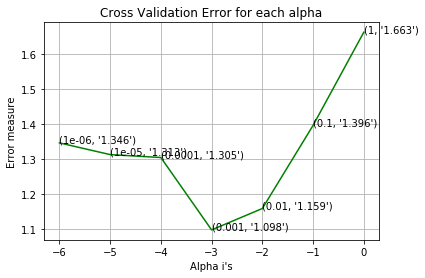

In [232]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xticks(np.log10(alpha))
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")

In [233]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best alpha =  0.001 The train log loss is: 0.643184817491
For values of best alpha =  0.001 The cross validation log loss is: 1.10642987743
For values of best alpha =  0.001 The test log loss is: 1.06627638134


#### 4.3.2.2. Testing model with best hyper parameters

Number of mis-classified points : 0.36390977443609024
-------------------- Confusion matrix --------------------


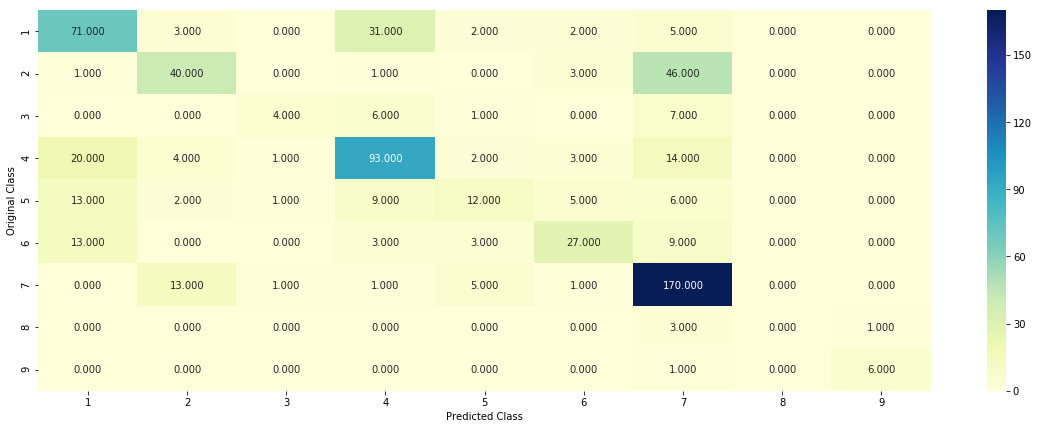

-------------------- Precision matrix (Column Sum=1) --------------------


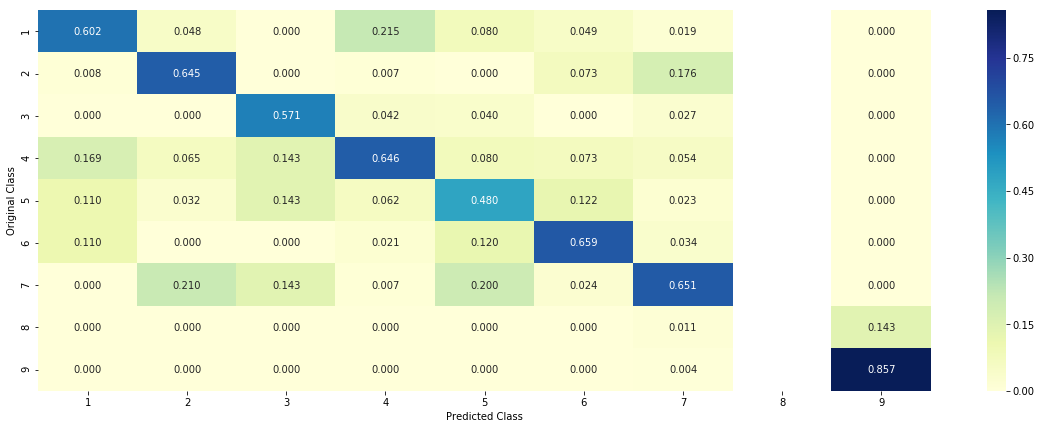

-------------------- Recall matrix (Row sum=1) --------------------


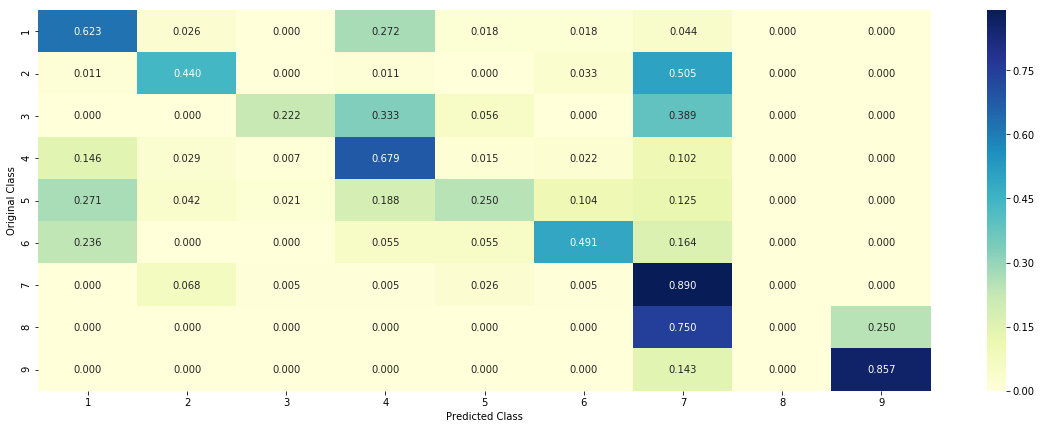

In [261]:
pred_y = sig_clf.predict(test_x_onehotCoding)
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((pred_y - y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,pred_y)

#### 4.3.2.3. Feature Importance, Correctly Classified point

In [235]:
test_point_index = 6
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[ 0.0495  0.132   0.0048  0.0333  0.0227  0.0115  0.7399  0.0049  0.0012]]
Actual Class : 7
--------------------------------------------------
179 Text feature [technology] present in test data point
192 Text feature [constitutively] present in test data point
259 Text feature [constitutive] present in test data point
327 Text feature [expressing] present in test data point
386 Text feature [ba] present in test data point
393 Text feature [nonsense] present in test data point
429 Text feature [f3] present in test data point
443 Text feature [loss] present in test data point
461 Text feature [oncogene] present in test data point
484 Text feature [recurrence] present in test data point
489 Text feature [oncogenes] present in test data point
498 Text feature [oncoprotein] present in test data point
Out of the top  500  features  12 are present in query point


#### 4.3.2.4. Feature Importance, Inorrectly Classified point

In [244]:
test_point_index = 29
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[ 0.0752  0.3236  0.0191  0.0675  0.0578  0.0454  0.3983  0.0074  0.0057]]
Actual Class : 2
--------------------------------------------------
Out of the top  500  features  0 are present in query point


## 4.4. Linear Support Vector Machines

### 4.4.1. Hyper paramter tuning

In [245]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    ## Balancing the classes
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge')
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs))

for C = 1e-05
Log Loss : 1.33929472357
for C = 0.0001
Log Loss : 1.31468994859
for C = 0.001
Log Loss : 1.23809579101
for C = 0.01
Log Loss : 1.12570742415
for C = 0.1
Log Loss : 1.37734071173
for C = 1
Log Loss : 1.73696458863
for C = 10
Log Loss : 1.74552657346
for C = 100
Log Loss : 1.74552403813


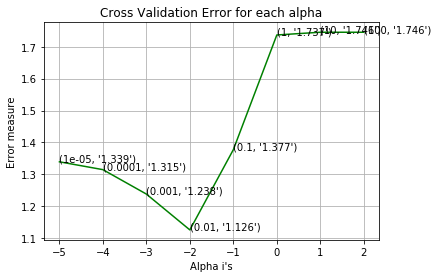

In [246]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")

In [247]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best alpha =  0.01 The train log loss is: 0.74998040828
For values of best alpha =  0.01 The cross validation log loss is: 1.12765838006
For values of best alpha =  0.01 The test log loss is: 1.1344707207


### 4.4.2. Testing model with best hyper parameters

Number of mis-classified points : 0.3804511278195489
-------------------- Confusion matrix --------------------


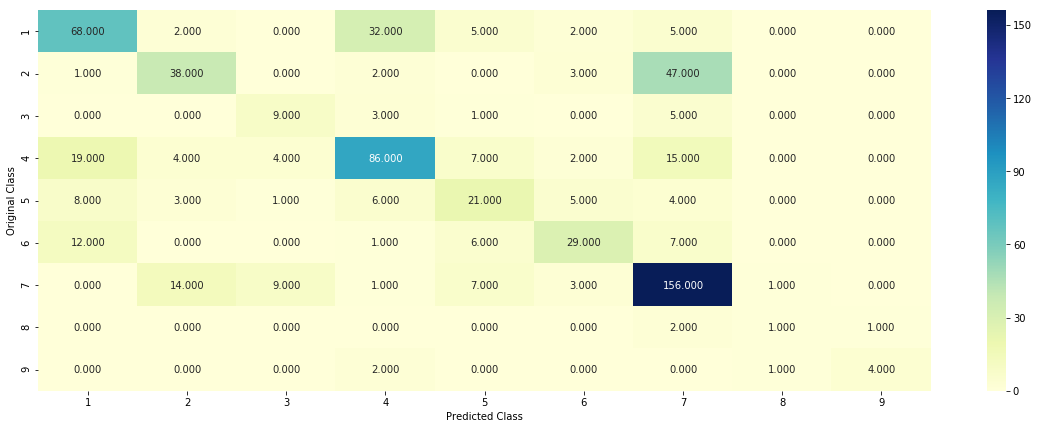

-------------------- Precision matrix (Column Sum=1) --------------------


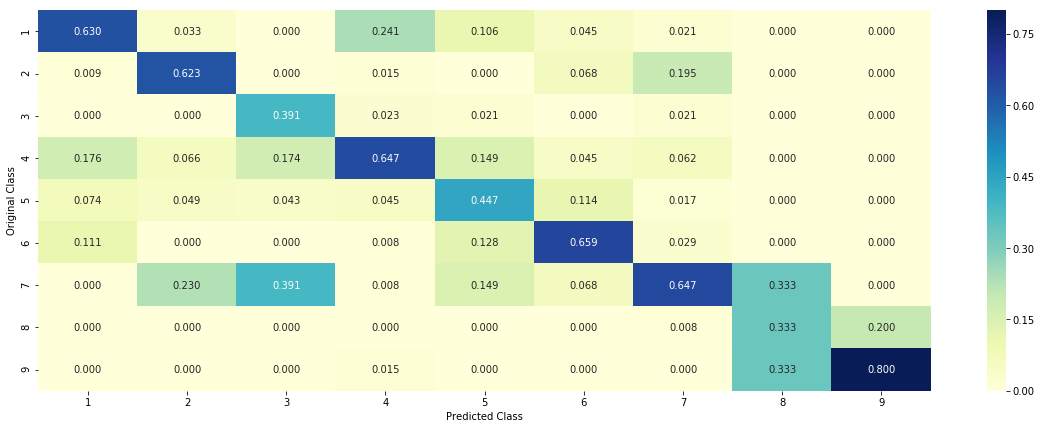

-------------------- Recall matrix (Row sum=1) --------------------


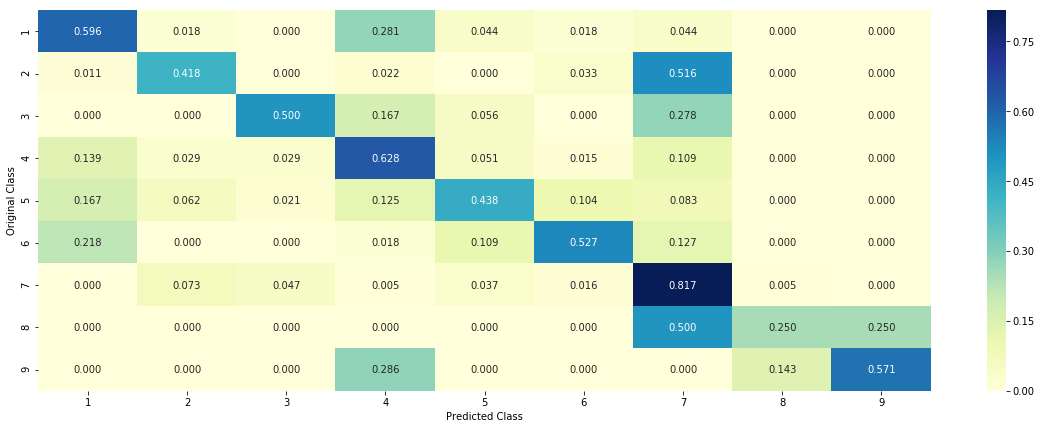

In [263]:
pred_y = sig_clf.predict(test_x_onehotCoding)
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((pred_y - y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,pred_y)

### 4.3.3. Feature Importance

#### 4.3.3.1. For Correctly classified point

In [249]:
test_point_index = 2
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[ 0.0404  0.0516  0.0047  0.0625  0.0165  0.7549  0.062   0.0035  0.0037]]
Actual Class : 6
--------------------------------------------------
118 Text feature [spermatogenesis] present in test data point
122 Text feature [screens] present in test data point
194 Text feature [triazole] present in test data point
197 Text feature [theoretical] present in test data point
200 Text feature [brca] present in test data point
229 Text feature [centrosome] present in test data point
230 Text feature [sterility] present in test data point
232 Text feature [simplex] present in test data point
239 Text feature [bach1wt] present in test data point
240 Text feature [flex7] present in test data point
241 Text feature [brca1fh] present in test data point
242 Text feature [brca1flex2] present in test data point
243 Text feature [brca1tr] present in test data point
244 Text feature [flex2] present in test data point
245 Text feature [4543] present in 

#### 4.3.3.2. For Incorrectly classified point

In [251]:
test_point_index = 14
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[ 0.0183  0.0381  0.0025  0.0136  0.009   0.0049  0.9091  0.0022  0.0023]]
Actual Class : 2
--------------------------------------------------
64 Text feature [stat] present in test data point
66 Text feature [transforming] present in test data point
67 Text feature [technology] present in test data point
82 Text feature [cysteine] present in test data point
83 Text feature [constitutively] present in test data point
84 Text feature [expressing] present in test data point
92 Text feature [jak] present in test data point
106 Text feature [constitutive] present in test data point
107 Text feature [3t3] present in test data point
114 Text feature [grew] present in test data point
126 Text feature [oncogenes] present in test data point
127 Text feature [nude] present in test data point
142 Text feature [forwards] present in test data point
154 Text feature [transformed] present in test data point
170 Text feature [activated] present in te

## 4.5 Random Forest Classifier with one hot encoded features

### 4.5.1. Hyper paramter tuning

In [252]:
alpha = [100,200,500,1000,2000]   ## May try other values
max_depth = [5, 10]          ## May try other values
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

for n_estimators = 100 and max depth =  5
Log Loss : 1.23753077658
for n_estimators = 100 and max depth =  10
Log Loss : 1.19003933482
for n_estimators = 200 and max depth =  5
Log Loss : 1.21817400826
for n_estimators = 200 and max depth =  10
Log Loss : 1.1813563808
for n_estimators = 500 and max depth =  5
Log Loss : 1.21025784197
for n_estimators = 500 and max depth =  10
Log Loss : 1.1724671571
for n_estimators = 1000 and max depth =  5
Log Loss : 1.20515119472
for n_estimators = 1000 and max depth =  10
Log Loss : 1.17241669711
for n_estimators = 2000 and max depth =  5
Log Loss : 1.20359145042
for n_estimators = 2000 and max depth =  10
Log Loss : 1.17145826396


In [253]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], n_jobs=-1)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best estimator =  2000 The train log loss is: 0.717635708882
For values of best estimator =  2000 The cross validation log loss is: 1.16692278811
For values of best estimator =  2000 The test log loss is: 1.16288358989


### 4.5.2. Testing model with best hyper parameters (One Hot Encoding)

Number of mis-classified points : 0.4045112781954887
-------------------- Confusion matrix --------------------


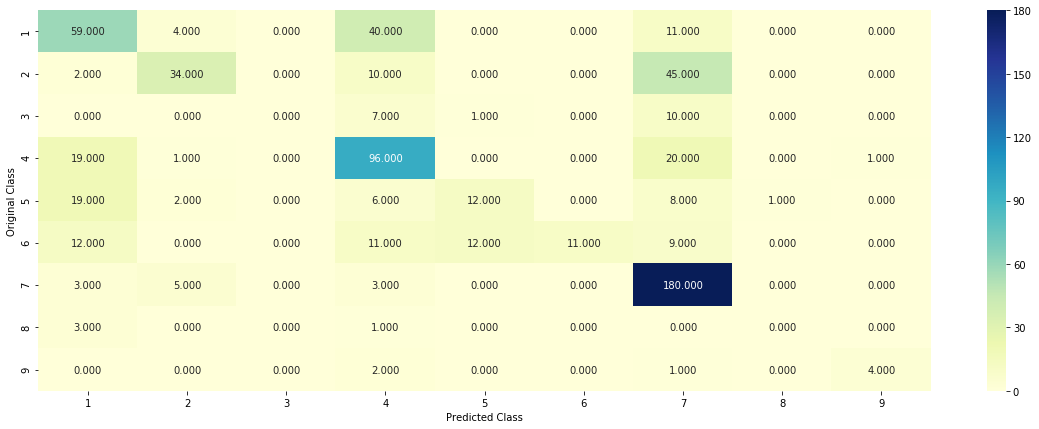

-------------------- Precision matrix (Column Sum=1) --------------------


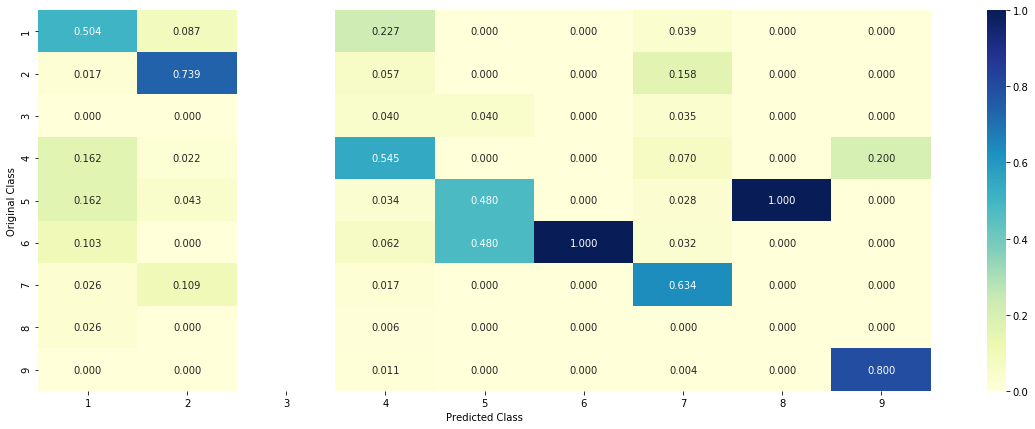

-------------------- Recall matrix (Row sum=1) --------------------


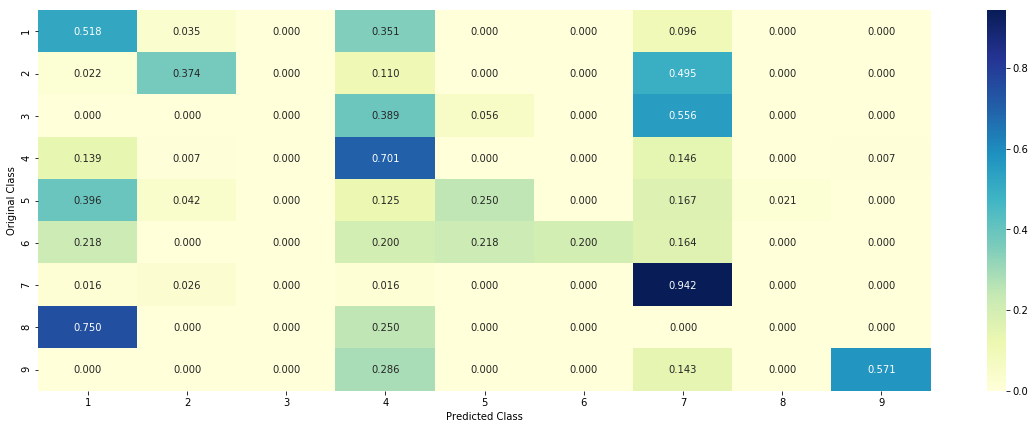

In [265]:
pred_y = sig_clf.predict(test_x_onehotCoding)
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((pred_y - y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,pred_y)

### 4.5.3. Feature Importance

#### 4.5.3.1. Correctly Classified point

In [266]:
test_point_index = 3
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[ 0.0493  0.0722  0.0181  0.0422  0.0478  0.0325  0.7288  0.0047  0.0044]]
Actual Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point
1 Text feature [activating] present in test data point
2 Text feature [tyrosine] present in test data point
3 Text feature [activation] present in test data point
4 Text feature [constitutive] present in test data point
5 Text feature [activated] present in test data point
7 Text feature [function] present in test data point
8 Text feature [inhibitors] present in test data point
10 Text feature [oncogenic] present in test data point
11 Text feature [inhibitor] present in test data point
12 Text feature [signaling] present in test data point
13 Text feature [missense] present in test data point
14 Text feature [treatment] present in test data point
15 Text feature [receptor] present in test data point
16 Text feature [loss] present in test data 

#### 4.5.3.2. Inorrectly Classified point

In [275]:
test_point_index = 12
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[ 0.2021  0.1431  0.0258  0.3365  0.067   0.0518  0.1569  0.0078  0.0089]]
Actual Class : 2
--------------------------------------------------
1 Text feature [activating] present in test data point
2 Text feature [tyrosine] present in test data point
3 Text feature [activation] present in test data point
5 Text feature [activated] present in test data point
6 Text feature [suppressor] present in test data point
7 Text feature [function] present in test data point
10 Text feature [oncogenic] present in test data point
12 Text feature [signaling] present in test data point
13 Text feature [missense] present in test data point
14 Text feature [treatment] present in test data point
16 Text feature [loss] present in test data point
22 Text feature [downstream] present in test data point
23 Text feature [constitutively] present in test data point
24 Text feature [growth] present in test data point
28 Text feature [stability] present in test

## 4.7 Stacking models

### 4.7.1 Hyper parameter tuning

**Note:** The optimal values of the hyper parameters of the base learners is taken from the individual models built above. Here we only do the hyperparameter tuning for the meta classifier

In [280]:
## clf1 is logistic regression with balanced classes
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

## clf2 is SVM with balanced classes
clf2 = SGDClassifier(alpha=0.01, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

## clf3 is Naive Bayes Model
clf3 = MultinomialNB(alpha=0.1)
clf3.fit(train_x_onehotCoding, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, y_train)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(y_cv, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, y_train)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(y_cv, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, y_train)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(y_cv, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
min_error = 999
## Meta Classifier is Logistic Regression
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, y_train)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(y_cv, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(y_cv, sclf.predict_proba(cv_x_onehotCoding))
    if min_error > log_error:
        min_error = log_error
        best_alpha = i

Logistic Regression :  Log Loss: 1.10
Support vector machines : Log Loss: 1.13
Naive Bayes : Log Loss: 1.26
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.176
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.015
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.466
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.117
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.163
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.327


### 4.7.2 Testing the model with the best hyper parameters

Log loss (train) on the stacking classifier : 0.648270982351
Log loss (CV) on the stacking classifier : 1.11745015139
Log loss (test) on the stacking classifier : 1.14096991613
Number of missclassified point : 0.36390977443609024
-------------------- Confusion matrix --------------------


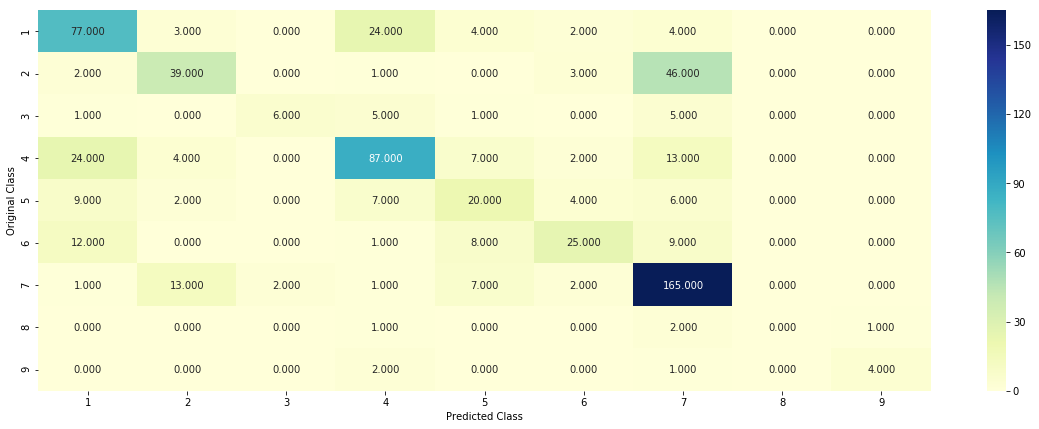

-------------------- Precision matrix (Column Sum=1) --------------------


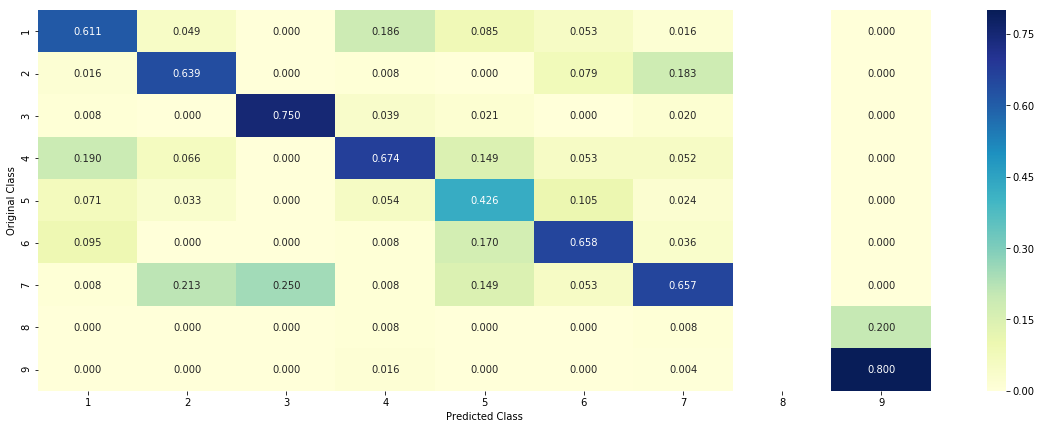

-------------------- Recall matrix (Row sum=1) --------------------


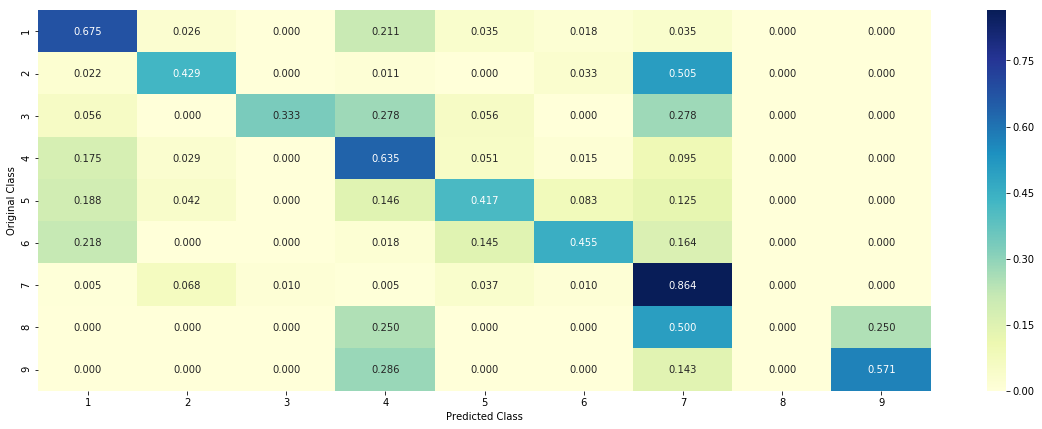

In [282]:
lr = LogisticRegression(C=best_alpha)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, y_train)

log_error = log_loss(y_train, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(y_cv, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(y_test, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test, sclf.predict(test_x_onehotCoding))

### 4.7.3 Maximum Voting classifier
This is another type of Ensemble method which takes in multiple base learners and the meta-classifier is nothing but the majority vote of all the base learners

Log loss (train) on the VotingClassifier : 0.726762774027
Log loss (CV) on the VotingClassifier : 1.07851742085
Log loss (test) on the VotingClassifier : 1.09389546133
Number of missclassified point : 0.38345864661654133
-------------------- Confusion matrix --------------------


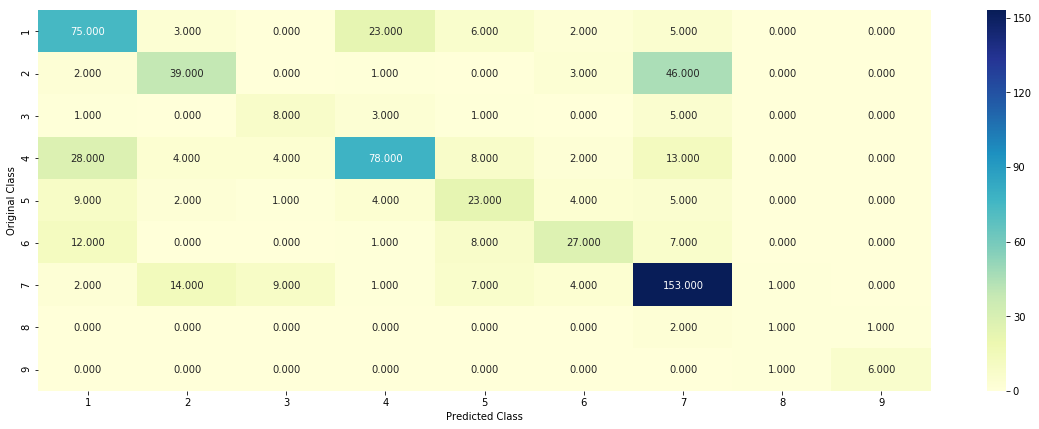

-------------------- Precision matrix (Column Sum=1) --------------------


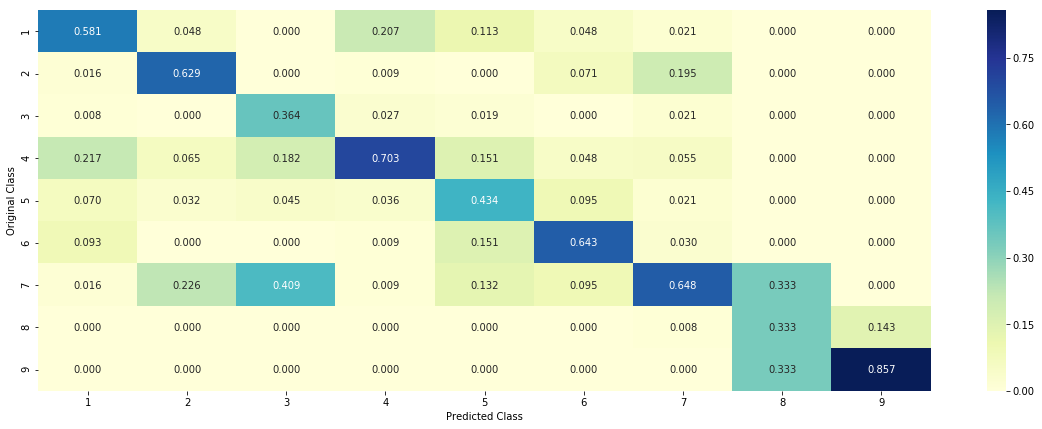

-------------------- Recall matrix (Row sum=1) --------------------


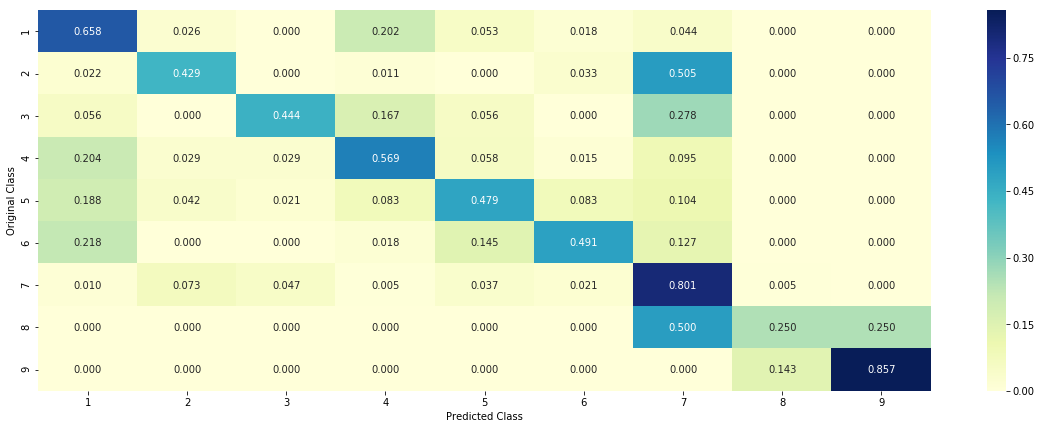

In [285]:
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('nb', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, y_train)
print("Log loss (train) on the VotingClassifier :", log_loss(y_train, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(y_cv, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(y_test, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test, vclf.predict(test_x_onehotCoding))

# 5. Assignments

* Apply All the models with tf-idf features (Replace CountVectorizer with tfidfVectorizer and run the same cells)